In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import cv2
import h5py
from tqdm import tqdm_notebook
from keras.preprocessing.image import load_img
from skimage.transform import resize
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# ref
# https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification

In [3]:
TRAIND = 'data/train/'
TRAIN_IMGS = TRAIND+'images/'
TRAIN_MASKS = TRAIND+'masks/'

In [4]:
# resnet expects 224 => better results with size 224?
size_original = (101, 101)
size_target = (256, 256)

def upsample(img):
    if size_original == size_target:
        return img
    return resize(img, size_target, mode='constant', preserve_range=True)

def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, size_original, mode='constant', preserve_range=True)

# Extraction

In [5]:
train_df = pd.read_csv('data/train.csv', index_col='id', usecols=[0])
depth_df = pd.read_csv('data/depths.csv', index_col='id')
# depth dataframes
train_ddf = train_df.join(depth_df)
test_ddf = depth_df[~depth_df.index.isin(train_ddf.index)]

In [6]:
# images to include in df
imgs = [np.array(load_img(TRAIN_IMGS+img_id+'.png', color_mode = "grayscale")) / 255 \
       for img_id in tqdm_notebook(train_df.index)]

In [7]:
train_ddf['masks'] = [np.array(load_img(TRAIN_MASKS+img_id+'.png', color_mode = "grayscale")) / 255 \
       for img_id in tqdm_notebook(train_df.index)]

In [8]:
train_ddf['imgs'] = imgs
train_ddf['imgs_sum'] = [np.sum(x) for x in imgs]
train_ddf['masks_sum'] = [np.sum(y) for y in train_ddf['masks'].values]

In [9]:
# divide into classes to ensure val/train is valid
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_ddf['coverage'] = train_ddf.masks.map(np.sum) / (3 * pow(np.sum(size_original), 2))        
train_ddf['coverage_class'] = train_ddf.coverage.map(cov_to_class)

In [10]:
# new data set for training the identifier 
train_ddf['salt'] = np.where(train_ddf['masks_sum']>0, 1, 0)

In [11]:
train_ddf[['salt']].to_csv('salt-identifier.csv')

# Cleaning

In [11]:
# # Remove 80 blank images
# train_ddf = train_ddf[train_ddf.imgs_sum > 0]
# len(train_ddf)

In [12]:
# use easy images for first model of transfer learning
# e = (101*101) * 0.01
# train_ddf = train_ddf[(train_ddf.masks_sum > e) | (train_ddf.masks_sum == 0)]
# len(train_ddf)

# Resize

In [10]:
x_train = np.array(train_ddf.imgs.map(upsample).tolist()).reshape(-1, size_target[0], size_target[1], 1)
y_train = np.array(train_ddf.masks.map(upsample).tolist()).reshape(-1, size_target[0], size_target[1], 1)

/Users/brennangebotys/miniconda3/envs/playground/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


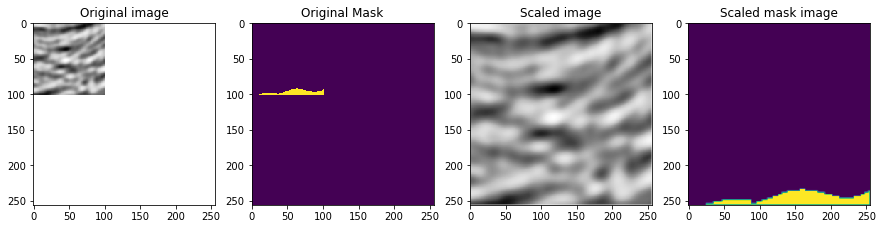

In [11]:
# sanity check
i = 4
tmp_img = np.zeros(size_target, dtype=np.float32)
tmp_mask = np.zeros(size_target, dtype=np.float32)
tmp_img[:size_original[0], :size_original[1]] = train_ddf.imgs.loc[train_ddf.index[i]]
tmp_mask[:size_original[0], :size_original[1]] = train_ddf.masks.loc[train_ddf.index[i]]

fix, axs = plt.subplots(1, 4, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(tmp_mask)
axs[1].set_title("Original Mask")

axs[2].imshow(x_train[i].squeeze(), cmap="Greys")
axs[2].set_title("Scaled image")
axs[3].imshow(y_train[i].squeeze())
axs[3].set_title("Scaled mask image")
plt.show()

# Split & Save

In [12]:
xtrain, xval, ytrain, yval, \
dtrain, dval, idtrain, idval = train_test_split(x_train, y_train, \
                                                train_ddf.z.values, [a.encode('utf8') for a in train_ddf.index.values], \
                                                stratify=train_ddf.coverage_class, test_size=0.1)

In [17]:
# path = 'tfmodel/'
path = '../data/processed-data/'

In [18]:
data = [xtrain, xval, ytrain, yval, dtrain, dval, idtrain, idval]
names = ['xtrain', 'xval', 'ytrain', 'yval', 'dtrain', 'dval', 'idtrain', 'idval']

for d, n in zip(data, names): 
    with h5py.File(path+'{}.h5'.format(n), 'w') as hf:
        hf.create_dataset(n, data=d)

OSError: Unable to create file (unable to open file: name = '../data/processed-data/xtrain.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602)

In [2]:
# !ipython nbconvert --to=python data-extraction.ipynb

[TerminalIPythonApp] WARNING | Subcommand `ipython nbconvert` is deprecated and will be removed in future versions.
[TerminalIPythonApp] WARNING | You likely want to use `jupyter nbconvert` in the future
[NbConvertApp] Converting notebook data-extraction.ipynb to python
[NbConvertApp] Writing 3240 bytes to data-extraction.py
